In [1]:
#common imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#text preprocessing
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from collections import Counter
#deal with tensors
import torch   
from torchsummary import summary
#handling text data
from torchtext.legacy import data   

from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline

## Text Preprocessing

In [2]:
df = pd.read_csv('Dataset 1.csv', encoding = "ISO-8859-1")
df.columns = ['text', 'label']

In [3]:
nltk.download('stopwords')
english_stops = set(stopwords.words('english'))
nltk.download('punkt')
puncset = list(string.punctuation)
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SNYPHAR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SNYPHAR\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SNYPHAR\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
def preprocessData(text):
  sentence = [lemmatizer.lemmatize(i, pos='v') for i in text.split() if i not in puncset and i not in english_stops]
  # sentence = [lemmatizer.lemmatize(i, pos='v') for i in text.split() if i not in puncset]
  sentence = [w for w in sentence if w.isalpha()]
  return ' '.join(sentence)

In [5]:
df['text'] = df.text.map(lambda x: preprocessData(x))

In [6]:
df['text']

0                                           real good miss
1                                               read manga
2                                                         
3          Need send accountant I even refer Those support
4                                                ADD ME ON
                               ...                        
10309    No Depression G Herbo mood do stress people de...
10310    What depression succumb brain make feel like n...
10311    Ketamine Nasal Spray Shows Promise Against Sui...
10312                        dont mistake bad day everyone
10313                                                     
Name: text, Length: 10314, dtype: object

In [7]:
sentence_length = []
count = Counter()
def CountWords():
    for i in df.text:
        temp = i.split()
        sentence_length.append(len(temp))
        for j in temp:
            count[j] += 1
    num_words = len(count)
    max_length = max(sentence_length)
    min_length = min(sentence_length)
    print('num_words: ',num_words,' max_length: ',max_length,' min_length: ',min_length)
CountWords()

num_words:  12883  max_length:  43  min_length:  0


In [8]:
df.drop(df.index[df['text'] == ""], inplace = True)

In [9]:
CountWords()


num_words:  12883  max_length:  43  min_length:  0


In [10]:
df.to_csv("train.csv",encoding='utf-8')

## Word Embedding

In [11]:
#Reproducing same results
SEED = 2019

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True 

In [12]:
TEXT = data.Field(tokenize='moses',batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

In [13]:
fields = [(None, None), ('text',TEXT),('label', LABEL)]

In [14]:
#loading custom dataset
training_data=data.TabularDataset(path = 'train.csv',format = 'csv',fields = fields,skip_header = True)

#print preprocessed text
print(vars(training_data.examples[0]))

{'text': ['real', 'good', 'miss'], 'label': '0'}


In [15]:
import random
train_data, test_data = training_data.split(split_ratio=0.8, random_state = random.seed(SEED))
train_data, valid_data = train_data.split(split_ratio=0.8, random_state = random.seed(SEED))

In [16]:
#initialize glove embeddings
TEXT.build_vocab(train_data,min_freq=3,vectors = "glove.6B.100d")  

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  

#Word dictionary
print(TEXT.vocab.stoi)  

Size of TEXT vocabulary: 2324
Size of LABEL vocabulary: 2
[('I', 1783), ('depression', 791), ('get', 553), ('go', 442), ('like', 330), ('love', 328), ('good', 271), ('make', 263), ('see', 232), ('know', 231)]
defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x00000269526E7160>>, {'<unk>': 0, '<pad>': 1, 'I': 2, 'depression': 3, 'get': 4, 'go': 5, 'like': 6, 'love': 7, 'good': 8, 'make': 9, 'see': 10, 'day': 11, 'know': 12, 'think': 13, 'time': 14, 'u': 15, 'Depression': 16, 'The': 17, 'feel': 18, 'new': 19, 'one': 20, 'thank': 21, 'want': 22, 'work': 23, 'take': 24, 'come': 25, 'back': 26, 'much': 27, 'really': 28, 'say': 29, 'look': 30, 'watch': 31, 'You': 32, 'need': 33, 'im': 34, 'lol': 35, 'great': 36, 'people': 37, 'help': 38, 'today': 39, 'use': 40, 'try': 41, 'gonna': 42, 'would': 43, 'My': 44, 'anxiety': 45, 'well': 46, 'Just': 47, 'still': 48, 'wait': 49, 'happy': 50, 'hope': 51, 'even': 52, 'night': 53, 'Good': 54, 'haha': 55, 'It': 56, '

In [17]:
#check whether cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

#set batch size
BATCH_SIZE = 64

#Load an iterator
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)
test_iterator = data.BucketIterator(
    test_data, 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

## Model Creation And Training

In [44]:
import torch.nn as nn

class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout,nonlinearity):
        
        #Constructor
        super().__init__()          
        
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #rnn layer
        self.rnn = nn.RNN(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True,
                           nonlinearity=nonlinearity)
        
        #dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        #activation function
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        
        #text = [batch size,sent_length]
        embedded = self.embedding(text)
        #embedded = [batch size, sent_len, emb dim]
      
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(),batch_first=True)
        #####################################################
        packed_output, hidden = self.rnn(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
        
        #concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]
        dense_outputs=self.fc(hidden)

        #Final activation function
        outputs=self.act(dense_outputs)
        
        return outputs

In [45]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 64
num_output_nodes = 1
num_layers = 4
bidirection = False
dropout = 0.2
lr = 0.0001
#instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers, 
                   bidirectional = True, dropout = dropout,nonlinearity='relu')

In [20]:
#architecture
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

#Initialize the pretrained embedding
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

print(pretrained_embeddings.shape)

classifier(
  (embedding): Embedding(2324, 100)
  (rnn): RNN(100, 64, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (act): Sigmoid()
)
The model has 328,273 trainable parameters
torch.Size([2324, 100])


In [21]:
import torch.optim as optim

#define optimizer and loss
optimizer = optim.Adam(model.parameters(),lr=lr)
criterion = nn.BCELoss()

#define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
#push to cuda if available
model = model.to(device)
criterion = criterion.to(device)


In [22]:
def train(model, iterator, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        text, text_lengths = batch.text   
        
        #convert to 1D tensor
        predictions = model(text, text_lengths).squeeze()  
        
        #compute the loss
        loss = criterion(predictions, batch.label)        
        
        #compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [23]:
def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            #retrieve text and no. of words
            text, text_lengths = batch.text
            
            #convert to 1d tensor
            predictions = model(text, text_lengths).squeeze()
            
            #compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [24]:
def test(model, iterator, optimizer):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        text, text_lengths = batch.text   
        
        #convert to 1D tensor
        predictions = model(text, text_lengths).squeeze()  
             
        
        #compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
           
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [30]:
N_EPOCHS = 20
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    #evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    print(f'\tEpoch:{epoch+1}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

	Epoch:1
	Train Loss: 0.071 | Train Acc: 97.88%
	 Val. Loss: 0.149 |  Val. Acc: 95.81%
	Epoch:2
	Train Loss: 0.071 | Train Acc: 97.78%
	 Val. Loss: 0.148 |  Val. Acc: 95.93%
	Epoch:3
	Train Loss: 0.069 | Train Acc: 97.82%
	 Val. Loss: 0.154 |  Val. Acc: 95.87%
	Epoch:4
	Train Loss: 0.066 | Train Acc: 98.03%
	 Val. Loss: 0.156 |  Val. Acc: 95.63%
	Epoch:5
	Train Loss: 0.060 | Train Acc: 98.14%
	 Val. Loss: 0.160 |  Val. Acc: 95.93%
	Epoch:6
	Train Loss: 0.060 | Train Acc: 98.02%
	 Val. Loss: 0.158 |  Val. Acc: 95.93%
	Epoch:7
	Train Loss: 0.057 | Train Acc: 98.17%
	 Val. Loss: 0.154 |  Val. Acc: 96.11%
	Epoch:8
	Train Loss: 0.052 | Train Acc: 98.39%
	 Val. Loss: 0.168 |  Val. Acc: 95.87%
	Epoch:9
	Train Loss: 0.048 | Train Acc: 98.51%
	 Val. Loss: 0.164 |  Val. Acc: 95.99%
	Epoch:10
	Train Loss: 0.045 | Train Acc: 98.61%
	 Val. Loss: 0.176 |  Val. Acc: 95.57%
	Epoch:11
	Train Loss: 0.047 | Train Acc: 98.42%
	 Val. Loss: 0.168 |  Val. Acc: 95.93%
	Epoch:12
	Train Loss: 0.038 | Train Acc:

## Prediction, Accuracy Result

In [31]:
# Evaluation Function

def test(model, iterator, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            labels = batch.label.to(device)
            text = text.to(device)
            text_len = text_lengths.to(device)
            output = model(text, text_lengths)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['NON-DEPRESSIVE', 'DEPRESSIVE'])
    ax.yaxis.set_ticklabels(['NON-DEPRESSIVE', 'DEPRESSIVE'])

In [32]:
#load weights
path='saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();

#inference 
import spacy
nlp = spacy.blank('en')

def predict(model, sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  #tokenize the sentence 
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]          #convert to integer sequence
    length = [len(indexed)]                                    #compute no. of words
    tensor = torch.LongTensor(indexed).to(device)              #convert to tensor
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words
    length_tensor = torch.LongTensor(length)                   #convert to tensor
    prediction = model(tensor, length_tensor)                  #prediction 
    pred = prediction.cpu().detach().numpy()
    if pred[0] > 0.5:
        print('("',sentence,'") Prediction: Depressive :(')
    else:
        print('("',sentence,'") Prediction: Non-Depressive :)')
           

Classification Report:
              precision    recall  f1-score   support

           1     0.9696    0.8415    0.9010       492
           0     0.9513    0.9915    0.9710      1537

    accuracy                         0.9552      2029
   macro avg     0.9604    0.9165    0.9360      2029
weighted avg     0.9557    0.9552    0.9540      2029



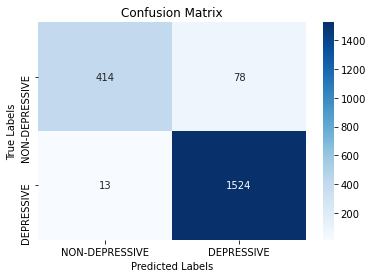

In [33]:
test(model, test_iterator)

In [34]:
#make predictions
predict(model, "This assignment got me into depression")
predict(model, "After finishing it i can die in peace!LOL!")
predict(model, "I am so Happy!")

(" This assignment got me into depression ") Prediction: Depressive :(
(" After finishing it i can die in peace!LOL! ") Prediction: Non-Depressive :)
(" I am so Happy! ") Prediction: Non-Depressive :)
